# Predição de Yield/TSC com SVM/KNN

## Definições

In [1]:
DATASET = 'b2s'  # b2s ou bfs
TYPE = "multiespectral"
SHOW_INFO = True

DSHAPE = (43, 53)
# DSHAPE = (53, 53)
# DSHAPE = (80, 80)

BALANCE_DATA = True
USE_TEST_AS_VAL = False
NORMALIZE_DATA = False
TRIAL = 'ML_TESTING'
COMMENTS = 'Teste com outros algoritmos de ML'
DAS = None
USE_FUNGICIDE = True

N_PCA_COMPONENTS = 100

SHAPE = (DSHAPE[0], DSHAPE[1], 4)
TO_FLATTEN = True
FLATTEN_SHAPE = DSHAPE[0]*DSHAPE[1]

TRANSFORMATION = 'NVDI'
AUGMENT = None
# None, simple, default ou advanced
"""
#### AUGMENT: Tipo de aumento de dados:
- None: nenhuma técnica de aumento de dados;
- simple: irá realizar flips na imagem sem alterar a orientação do corte;
- default: irá realizar técnicas de rotação e flip; pode alterar a orientação e a localização do corte;
- advanced: várias técnicas, como rotação, alongamento e zoom; altera a nitidez do corte e produz distorções.
"""
TARGET = 'Eval'

In [2]:
import datetime
NOW = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [3]:
AUG_INC = 1
if AUGMENT is None:
    AUG_INC = 1
elif AUGMENT == 'simple':
    AUG_INC = 2
elif AUGMENT == 'default':
    AUG_INC = 4
elif AUGMENT == 'default' and SHAPE[0] == SHAPE[1]:
    AUG_INC = 6
elif AUGMENT == 'advanced':
    AUG_INC = 16
elif AUGMENT == 'advanced' and SHAPE[0] == SHAPE[1]:
    AUG_INC = 18

## Importação

In [4]:
from datetime import datetime
from os import listdir
from os.path import isfile, join
from time import time
import logging

import os
import glob
import random

import numpy as np
import pandas as pd\

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import svm
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [6]:
os.makedirs(f'svm{os.sep}reports{os.sep}TRIAL{TRIAL}', exist_ok=True)
with open(f'svm{os.sep}reports{os.sep}TRIAL{TRIAL}{os.sep}notes.md', 'w') as f:
    f.write(COMMENTS)

In [7]:
import util
from trainutils import *

In [8]:
TRANSFORMATIONS = {
    'NVDI': util.ndvi,
    'RDVI': util.rdvi,
    'OSAVI': util.osavi,
    'MSR': util.msr,
    'MCARI1': util.mcari1,
    'MCARI2': util.mcari2,
    'PSSRA': util.pssra,
    'G': util.g_rgb_ratio,
    "None": None
}
TRANSFORMATION = TRANSFORMATIONS[TRANSFORMATION]

## Funções para carregar os dados

### Metadados

In [9]:
dfs = dict()
for f in os.listdir("data"):
    if os.path.splitext(f)[-1] == '.csv':
        dfs[f] = pd.read_csv(os.path.join("data", f))
        
frames = []
for k in dfs:
    if DATASET in k and TYPE in k:
        frames.append(dfs[k])
metadata = pd.concat(frames)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,q170505tscrfl_fung_19_B1.tif,q170505tscrfl_fung_19_B2.tif,q170505tscrfl_fung_19_B3.tif,q170505tscrfl_fung_19_B4.tif,fung_19,1,4,19,17,Fungicide,1.0,6.055209
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,q170505tscrfl_fung_31_B1.tif,q170505tscrfl_fung_31_B2.tif,q170505tscrfl_fung_31_B3.tif,q170505tscrfl_fung_31_B4.tif,fung_31,2,7,31,19,Fungicide,1.0,4.081627
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,q170419tscrfl_fung_59_B1.tif,q170419tscrfl_fung_59_B2.tif,q170419tscrfl_fung_59_B3.tif,q170419tscrfl_fung_59_B4.tif,fung_59,3,12,59,10,Fungicide,1.0,4.612393


#### Adicionando data

In [10]:
from datetime import datetime

def extract_date(token):
    date = ''
    for s in token:
        if s.isdigit():
            date += s
    return datetime.strptime(date, '%y%m%d')

In [11]:
metadata['Date'] = metadata.apply(lambda x: extract_date(x['Instance'].split('_')[0]), axis=1)
metadata['Year'] = metadata.apply(lambda x: x.Date.year, axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,q170505tscrfl_fung_19_B1.tif,q170505tscrfl_fung_19_B2.tif,q170505tscrfl_fung_19_B3.tif,q170505tscrfl_fung_19_B4.tif,fung_19,1,4,19,17,Fungicide,1.0,6.055209,2017-05-05,2017
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,q170505tscrfl_fung_31_B1.tif,q170505tscrfl_fung_31_B2.tif,q170505tscrfl_fung_31_B3.tif,q170505tscrfl_fung_31_B4.tif,fung_31,2,7,31,19,Fungicide,1.0,4.081627,2017-05-05,2017
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,q170419tscrfl_fung_59_B1.tif,q170419tscrfl_fung_59_B2.tif,q170419tscrfl_fung_59_B3.tif,q170419tscrfl_fung_59_B4.tif,fung_59,3,12,59,10,Fungicide,1.0,4.612393,2017-04-19,2017


#### Ordenando por nome,crop,data

In [12]:
metadata = metadata.sort_values(['Name', 'Crop', 'Date'])
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,c160407tscrfl_fung_1,crop_tsc_2016_b2s,c160407tscrfl_fung_1_B1.tif,c160407tscrfl_fung_1_B2.tif,c160407tscrfl_fung_1_B3.tif,c160407tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,c160418tscrfl_fung_1,crop_tsc_2016_b2s,c160418tscrfl_fung_1_B1.tif,c160418tscrfl_fung_1_B2.tif,c160418tscrfl_fung_1_B3.tif,c160418tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,c160428tscrfl_fung_1,crop_tsc_2016_b2s,c160428tscrfl_fung_1_B1.tif,c160428tscrfl_fung_1_B2.tif,c160428tscrfl_fung_1_B3.tif,c160428tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016


#### Definindo a instância

Neste experimento vamos considerar cada plot individual como uma instância. Um plot é o conjunto de 4 diferentes bandas espectrais de uma data específica.

In [13]:
metadata['Name'] = metadata.apply(lambda x: f'{(x.Name.split("_")[0])}_{int(x.Name.split("_")[1]):03}', axis=1)

In [14]:
metadata['Instance'] = metadata.apply(lambda x: f'{x.Name}_{x.Crop}_{x.Date.year}{x.Date.month}{x.Date.day}', axis=1)

In [15]:
metadata.head()

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,c160407tscrfl_fung_1_B1.tif,c160407tscrfl_fung_1_B2.tif,c160407tscrfl_fung_1_B3.tif,c160407tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,c160418tscrfl_fung_1_B1.tif,c160418tscrfl_fung_1_B2.tif,c160418tscrfl_fung_1_B3.tif,c160418tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,c160428tscrfl_fung_1_B1.tif,c160428tscrfl_fung_1_B2.tif,c160428tscrfl_fung_1_B3.tif,c160428tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016
10,fung_001_crop_tsc_2016_b2s_2016511,crop_tsc_2016_b2s,c160511tscrfl_fung_1_B1.tif,c160511tscrfl_fung_1_B2.tif,c160511tscrfl_fung_1_B3.tif,c160511tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-05-11,2016
385,fung_001_crop_tsc_2017_b2s_2017419,crop_tsc_2017_b2s,q170419tscrfl_fung_1_B1.tif,q170419tscrfl_fung_1_B2.tif,q170419tscrfl_fung_1_B3.tif,q170419tscrfl_fung_1_B4.tif,fung_001,1,1,1,23,Fungicide,1.0,5.643749,2017-04-19,2017


In [16]:
for key in ['B1File', 'B2File', 'B3File', 'B4File']:
    metadata[key] = metadata.apply(lambda x: os.path.join('data', 'RAW', x['Crop'], x[key]), axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016


#### Definindo *Days after sowing*

In [17]:
sowing_2016 = datetime.strptime('2016-01-19', '%Y-%m-%d')
sowing_2017 = datetime.strptime('2017-01-24', '%Y-%m-%d')

def get_das(date):
    if date.year == 2016:
        return (date - sowing_2016).days
    elif date.year == 2017:
        return (date - sowing_2017).days

In [18]:
metadata['DAS'] = metadata.apply(lambda x: get_das(x.Date), axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year,DAS
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016,79
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016,90
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016,100


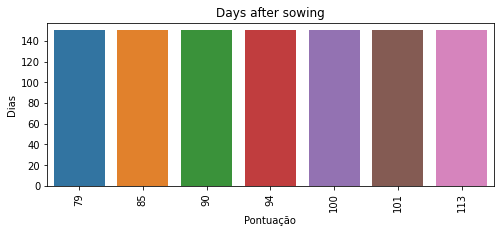

In [19]:
if SHOW_INFO:
    plt.figure(figsize=(8,3))
    evals = metadata['DAS'].value_counts()
    sns.barplot(evals.index, evals.values)
    plt.xticks(rotation='vertical')
    plt.xlabel('Pontuação')
    plt.ylabel('Dias')
    plt.title("Days after sowing")
    plt.show()

#### Normalizando DAS

Não é preciso normalizar o DAS.

In [20]:
# metadata['DAS'] = (metadata['DAS']-metadata['DAS'].min())/(metadata['DAS'].max()-metadata['DAS'].min())
# metadata['DAS']

### Split dos dados

Nesse experimento apenas os dados com DAS especificado serão considerados.

In [21]:
if DAS is not None:
    metadata = metadata[metadata.DAS == DAS]

Nesse experimento os dados com fungicidas serão desconsiderados.

In [22]:
if not USE_FUNGICIDE:
    metadata = metadata[metadata.Trial != 'Fungicide']

In [23]:
train_metadata = metadata.copy()

In [24]:
test_metadata = train_metadata.sample(frac=.2, random_state=11)
cond = test_metadata['Instance'].isin(train_metadata['Instance'])
train_metadata.drop(test_metadata[cond].index, inplace=True)
print("Tamanho dos dados de treinamento: ", len(train_metadata))
print("Tamanho dos dados de teste: ", len(test_metadata))

Tamanho dos dados de treinamento:  698
Tamanho dos dados de teste:  210


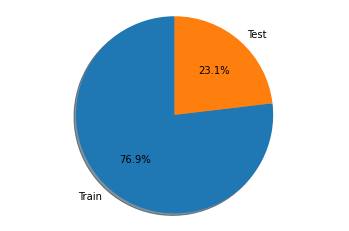

In [25]:
if SHOW_INFO:
    total = len(train_metadata)  + len(test_metadata)
    sizes = [len(train_metadata)/total, len(test_metadata)/total]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=["Train", "Test"], autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

In [26]:
print("Quantidade de instâncias (sem aumento de dados) totais:",
      len(metadata))
print("Quantidade de instâncias (sem aumento de dados) para treinamento:",
      len(train_metadata))
print("Quantidade de instâncias (sem aumento de dados) para teste:",
      len(test_metadata))

train_set = set(train_metadata.Instance)
test_set = set(test_metadata.Instance)
for i in test_set:
    assert not (i in train_set)

Quantidade de instâncias (sem aumento de dados) totais: 1050
Quantidade de instâncias (sem aumento de dados) para treinamento: 698
Quantidade de instâncias (sem aumento de dados) para teste: 210


#### Balanceamento dos dados

In [27]:
if BALANCE_DATA:
    g = train_metadata.groupby(TARGET, as_index=False)
    metadata_bal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().max(),
                                                           replace=True).reset_index(drop=True)))
    metadata_bal.reset_index(drop=True, inplace=True)
    train_metadata = metadata_bal

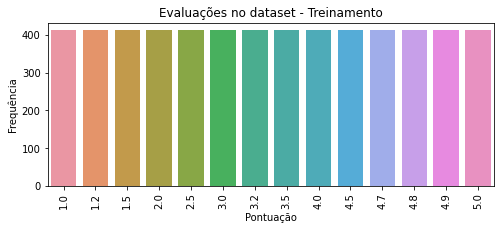

In [28]:
if SHOW_INFO:
    plt.figure(figsize=(8,3))
    evals = train_metadata['Eval'].value_counts()
    sns.barplot(evals.index, evals.values)
    plt.xticks(rotation='vertical')
    plt.xlabel('Pontuação')
    plt.ylabel('Frequência')
    plt.title("Evaluações no dataset - Treinamento")
    plt.show()

In [29]:
train_features = []
train_y = []
print("Loading trainning data")
for index, train_data in train_metadata.iterrows():
    index, data = util.process(train_data, 
                               im_shape=SHAPE, 
                               transform_f=TRANSFORMATION,
                               augment_type=None,
                               verbose_level=0)
    train_features.append(data[0])
    train_y.append(train_data[TARGET])
    
print("Loading test data")
test_features = []
test_y = []
for index, test_data in test_metadata.iterrows():
    index, data = util.process(test_data, 
                               im_shape=SHAPE, 
                               transform_f=TRANSFORMATION,
                               augment_type=None,
                               verbose_level=0)
    test_features.append(data[0])
    test_y.append(test_data[TARGET])

train_features = np.asarray(train_features)
train_y = np.asarray(train_y)
test_features = np.asarray(test_features)
test_y = np.asarray(test_y)

Loading trainning data


/home/lucas/Documentos/prod-milho/util.py:263: RuntimeWarning: invalid value encountered in true_divide
  im = (im[:, :, 3]-im[:, :, 1]) / (im[:, :, 3]+im[:, :, 1])


Loading test data


In [30]:
train_features.shape

(5768, 43, 53, 1)

In [31]:
train_features= train_features.reshape((train_features.shape[0], *DSHAPE))
test_features= test_features.reshape((test_features.shape[0], *DSHAPE))

In [32]:
def normalize(features, xmin=None, xmax=None):
    if xmin is None:
        xmin = np.min(features)
    if xmax is None:
        xmax = np.max(features)
    features = (features - xmin) / (xmax - xmin)
    return features

if NORMALIZE_DATA:
    train_features = normalize(train_features)
    test_features = normalize(test_features)

(5768, 43, 53)


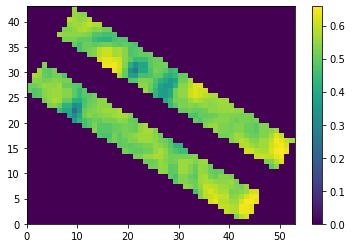

In [33]:
if SHOW_INFO:
    print(train_features.shape)
    plt.pcolormesh(train_features[0])
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    plt.close()

In [34]:
if TO_FLATTEN:
    train_features = np.reshape(np.asarray(train_features), (len(train_features), FLATTEN_SHAPE))
    test_features = np.reshape(np.asarray(test_features), (len(test_features), FLATTEN_SHAPE))

## PCA

In [35]:
n_components = N_PCA_COMPONENTS

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_features)
print("done in %0.3fs" % (time() - t0))

pca.components_.reshape((n_components, DSHAPE[0], DSHAPE[1]))

t0 = time()
X_train_pca = pca.transform(train_features)
X_test_pca = pca.transform(test_features)
print("done in %0.3fs" % (time() - t0))

done in 1.769s
done in 0.134s


## SVM classification model

In [36]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [48]:
model = svr_poly.fit(X_train_pca, train_y)

### Predições

In [49]:
test_predictions = model.predict(X_test_pca)

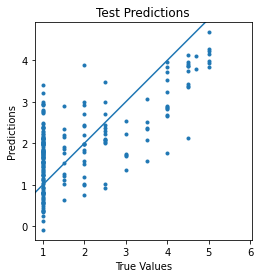

In [50]:
plt.scatter(test_y, test_predictions, marker='.')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Predictions')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])

plt.show()
plt.close()

In [52]:
r2 = r2_score(test_y, test_predictions)
print("SVM R2 =", r2)

SVM R2 = 0.463914817728608


## KNN classification model

In [40]:
rmse_val = [] #to store rmse values for different k
best_model = None
best_r2 = None
models = []
for K in range(5):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_pca, train_y)  #fit the model
    pred = model.predict(X_test_pca) #make prediction on test set
    error = sqrt(mean_squared_error(test_y,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
    r2 = r2_score(test_y, pred)
    print('R2 value for k= ' , K , 'is:', r2)
    
    if best_r2 is None or best_r2 < r2 or best_model is None:
        best_r2 = r2
        best_model = model
    models.append(model)

RMSE value for k=  1 is: 1.1894376422334652
R2 value for k=  1 is: 0.10437656981006449
RMSE value for k=  2 is: 1.1731215988610413
R2 value for k=  2 is: 0.12877936909443866
RMSE value for k=  3 is: 1.198992081117307
R2 value for k=  3 is: 0.08993016622575245
RMSE value for k=  4 is: 1.2243815251169134
R2 value for k=  4 is: 0.05097943156744211
RMSE value for k=  5 is: 1.2509836130021847
R2 value for k=  5 is: 0.009292773156820533


### Predições

In [41]:
test_predictions = best_model.predict(X_test_pca)

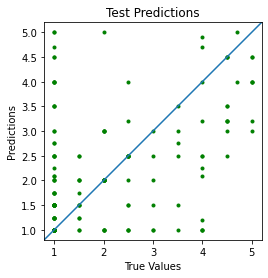

In [42]:
plt.scatter(test_y, test_predictions, marker='.', color='g')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Predictions')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])

plt.show()
plt.close()

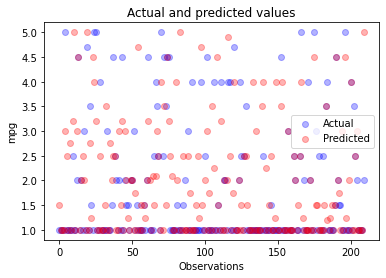

In [43]:
_, ax = plt.subplots()
ax.scatter(x = range(0, test_y.size), y=test_y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, test_predictions.size), y=test_predictions, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()
plt.close()

**Plot metrics and losses**

In [44]:
def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [45]:
# plt.plot(smooth_curve(history.history['mae']))
# plt.plot(smooth_curve(history.history['val_mae']))
# plt.title('MAE')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig(f'reports{os.sep}TRIAL{TRIAL}{os.sep}MAE{os.sep}{MODEL_NAME}_{NOW}.png')
# plt.show()
# plt.close()